### Machine Learning for Quantum State Tomography
Motivation: 

As the bit is the fundamental concept of classical information. Quantum information is built upon an analogous concept, the quantum bit, or qubit. Unlike classical bits, qubits can be present in any intermediate state between 0 and 1.
An n-qubit state is characterised by a density matrix which may be written as follows:
\begin{align}
	\rho = \frac{1}{2^{n}}\sum_{i_{1},i_{2},...,i_{n}=0}^{3}r_{i_{1},i_{2},...,i_{n}}\sigma_{i_{1}}\otimes\sigma_{i_{2}}\otimes.....\otimes\sigma_{i_{n}} 
\end{align}

This is a mathematical representation of a multi-qubit state, where $\sigma$’s are pauli matrices and $r$’s are measurements in respective basis. But when we prepare a quantum state on a real quantum computer and measure it in classical system, $\rho$ come out to be different. This is caused by the noise present in the quantum system which is not linear and hard to estimate. The error in ρ is caused by deviation in $r_{i_{1},i_{2},...,i_{n}}$ values. We are estimating this nonlinear, higher order deviation using machine learning techniques.

#### 1. Dataset Generation

In [ ]:
import numpy as np
import qutip as qt
import itertools
import os
from qutip.qobj import Qobj
import sympy as sp 
import markdown as md
from qiskit import QuantumCircuit,execute, BasicAer, IBMQ,transpile
from qiskit.quantum_info import DensityMatrix as dm
from qiskit.quantum_info import Statevector as sv
from qiskit.providers.aer.noise import NoiseModel
from IPython import display
from qiskit.providers.aer import AerSimulator, Aer
from qiskit.providers.fake_provider import FakeParis

In [ ]:
# Save account IBMq
provider =IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-11-24 14:00:02,329: Credentials are already in use. The existing account in the session will be replaced.


In [ ]:
provider=IBMQ.providers()[1] #Set the provider

In [ ]:
provider.backends() # We can see the backends available

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-skku', group='skku', project='skku-graduate')>,
 <IBMQBackend('ibmq_montreal') from IBMQ(hub='ibm-q-skku', group='skku', project='skku-graduate')>,
 <IBMQBackend('ibmq_toronto') from IBMQ(hub='ibm-q-skku', group='skku', project='skku-graduate')>,
 <IBMQBackend('ibmq_kolkata') from IBMQ(hub='ibm-q-skku', group='skku', project='skku-graduate')>,
 <IBMQBackend('ibmq_mumbai') from IBMQ(hub='ibm-q-skku', group='skku', project='skku-graduate')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q-skku', group='skku', project='skku-graduate')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q-skku', group='skku', project='skku-graduate')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q-skku', group='skku', project='skku-graduate')>,
 <IBMQBackend('ibmq_guadalupe') from IBMQ(hub='ibm-q-skku', group='skku', project='skku-graduate')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q-skku', group='skku', project='skku-graduate

In [ ]:
backend = provider.get_backend('ibm_oslo') # We choose the backend
fakebackend = FakeParis() # We choose the fake noisy backend

In [ ]:
# We build the noise model
noise_model = NoiseModel.from_backend(backend)
coupling_map = backend.configuration().coupling_map
basis_gates = noise_model.basis_gates

In [ ]:
def modelparams(Basis,rho):
    params =[]
    for i in range(len(Basis)):
        params.append(np.real(np.trace(np.matmul(Basis[i],rho))))
    return np.array(params)
    
def recon(Basis,param,d):
    rho=np.zeros(d)
    for i in range(len(Basis)):
        rho=rho+param[i]*Basis[i]
    return np.array(Qobj(rho/d).conj())

In [ ]:
# Helper function for sorting the detector counts of the measurement

from qiskit.ignis.verification import marginal_counts as mc
from qiskit.ignis.verification import count_keys as ck
def get_freq(m_counts,n,shots):
    k_idx = ck(n)
    freq = []
    for i in k_idx:
        try:
            freq.append(m_counts[i])
        except KeyError:
            freq.append(0
                        )
    return list(np.array(freq))

In [ ]:
from qiskit.providers.aer.noise import depolarizing_error

def get_counts(rho,BASIS,N):
    return np.random.binomial(N, np.real(np.trace(np.matmul(rho,BASIS))))/N

#Run the circuit with noise on quantum computer and return the counts
def IBM_counts(n,rho,meas,N):
   # rho_dm = dm(rho)
    idx = list(np.arange(n))
    #backend = BasicAer.get_backend('qasm_simulator')
    backend = provider.get_backend('ibmq_manila') # We choose the backend
    sim_noise = NoiseModel.from_backend(backend)
    error = depolarizing_error(0.5, 1)
    sim_noise.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3']) # Add depolarizing noise
    counts=[]
    circuit = QuantumCircuit(n)
    circuit.initialize(rho,idx) #Initialize the state
    circuit.unitary(meas,idx)   #Apply the measurement basis
    circuit.measure_all()    #Measure all the qubits
    job = execute(circuit,Aer.get_backend('qasm_simulator'),
                 coupling_map=coupling_map,
                 basis_gates=basis_gates,
                 noise_model=noise_model,
                 shots=N)
    counts=job.result().get_counts()
    return np.array(get_freq(mc(counts),n,N))/N

In [ ]:
def sim_counts(n,rho,meas,N):
    #rho_dm = dm(rho)
    idx = list(np.arange(n))
    backend = BasicAer.get_backend('qasm_simulator')
    counts=[]
    circuit = QuantumCircuit(n)
    circuit.initialize(rho,idx) #Initialize the state
    circuit.unitary(meas,idx)   #Apply the measurement basis
    circuit.measure_all()    #Measure all the qubits
    job = execute(circuit,Aer.get_backend('qasm_simulator'),
                 shots=N)
    counts=job.result().get_counts()
    return np.array(get_freq(mc(counts),n,N))/N

In [ ]:
#generate the pauli measurement basis for the n qubits
import functools as ft
def get_pauli_basis(n):
    pauli = [qt.qeye(2),qt.sigmax(),qt.sigmay(),qt.sigmaz()]
    basis = []
    for i in itertools.product(pauli, repeat=n):
        basis.append(ft.reduce(np.kron, i))
    return basis

In [ ]:
#Testing
#Run the circuit with noise on quantum computer and return the counts (TEST)
#Ghz state
n=3
state = np.array([1,0,0,0,0,0,0,1])/np.sqrt(2)
rho = dm(np.outer(state,state)).to_statevector() # We choose the state
basis = get_pauli_basis(n)
meas = basis[0]
N = 1000
counts = IBM_counts(n,rho,meas,N)
counts

array([0.4  , 0.012, 0.023, 0.058, 0.085, 0.026, 0.016, 0.38 ])

In [ ]:
sim_c = sim_counts(n,rho,meas,N)
sim_c

array([0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0.5])

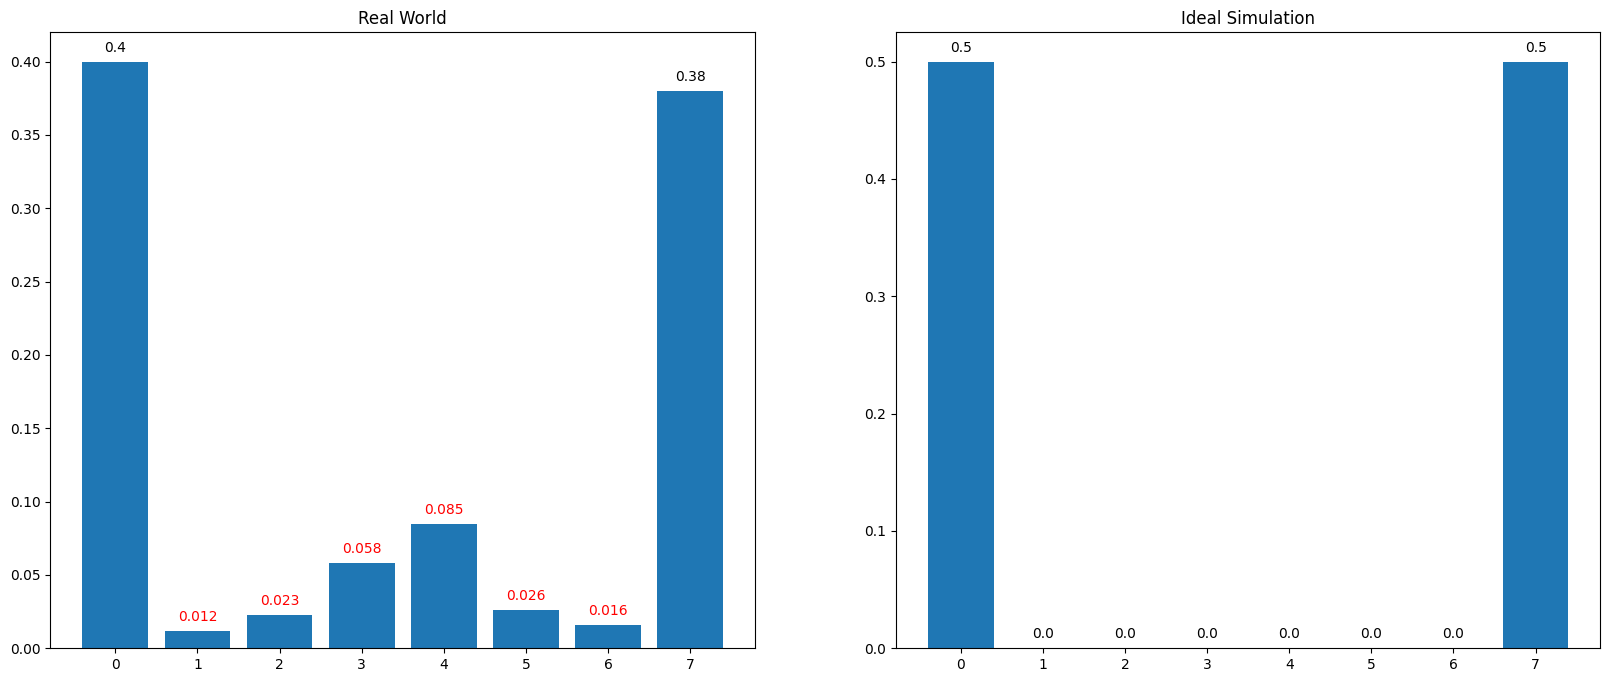

In [ ]:
# histogram of the counts on subplots
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(20, 8))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

ax0.bar(range(len(counts)), counts, align='center')
ax0.set_xticks(range(len(counts)))
ax0.set_xticklabels(range(len(counts)))
ax0.set_title('Real World')

ax1.bar(range(len(counts)), sim_c, align='center')
ax1.set_xticks(range(len(counts)))
ax1.set_xticklabels(range(len(counts)))
ax1.set_title('Ideal Simulation')

#annotate the counts
for i in range(len(counts)):
    
    if i==0 or i==len(counts)-1:
        ax0.annotate(str(counts[i]), xy=(i, counts[i]), xytext=(0, 5), textcoords='offset points', ha='center', va='bottom')
    else:
        ax0.annotate(str(counts[i]), xy=(i, counts[i]), xytext=(0, 5), textcoords='offset points', ha='center', va='bottom', color='red')
    
    ax1.annotate(str(sim_c[i]), xy=(i, sim_c[i]), xytext=(0, 5), textcoords='offset points' ,ha='center', va='bottom' )

plt.show()


In [ ]:
############### 2 qubits ####################
import tqdm
n = 2                           # Number of qubits
d=2**n                          # Dimension of the Hilbert space    
N=1000                          # Number of shots
Basis = get_pauli_basis(n)      # Measurement basis
Num=["".join(seq) for seq in itertools.product("IXYZ", repeat=n)] # Measurement basis labels
     
     
import pandas as pd
x_data =[]
y_data =[]
avg=100

for r in range(avg):
    psi=qt.rand_ket_haar(d)         # Random state
    rho=qt.ket2dm(psi)              # Density matrix
    rho=np.array(rho)               # Convert to array
    PSI=dm(rho).to_statevector()    # Convert to statevector
    y_hat=[]                        # Empty list for the ground truth of the state
    y_hat_ibm=[]                    # Empty list for the input features (Noisy Measurements)
    
    U=np.zeros((d,d),dtype = 'complex_')        # Empty matrix for the basis measurement
    for i in range(len(Num)):
        ei,ve=np.linalg.eig(Basis[i])          # Eigenvalues and eigenvectors of the basis
        p=[]                                   # Empty list for the probabilities
        f_ibm=[]                               # Empty list for the IBM measurements
        for j in range(d):
            B=ve[:,j]
            B_h=np.array([B])
            BASIS=B_h.conj().T*B_h
            p.append(np.real(np.trace(np.matmul(rho,BASIS))))          
            U[j,:]=ei[j]*B_h
        
        
        f_ibm = IBM_counts(n,PSI,U,N)
        y_hat.append(np.round(np.real(np.dot(p,ei)),6))
        y_hat_ibm.append(np.round(np.real(np.dot(f_ibm,ei)),6))
        
    x_data.append(y_hat_ibm)
    y_data.append(y_hat)
     
    #progress bar
    print('\r', 'Progress: ', r+1, '/', avg, end='')    

    #tqdm.tqdm._instances.clear()
    #print("Progress: ",r+1,"/",avg)
    
df=pd.DataFrame({'X_data': x_data, 'Y_data': y_data})
file="data_" + str(n) +"_"+ str(backend)+"_" +str(N)+ ".csv"
df.to_csv(file,  mode='a', index=False, header=False)
        

 Progress:  100 / 100

In [ ]:
#read the data
df = pd.read_csv(file, header=None)
X_data = df[0]
Y_data = df[1]

In [ ]:
#Convert the data to numpy arrays
import ast
X_data = np.array([ast.literal_eval
                     (X_data[i]) for i in range(len(X_data))])
Y_data = np.array([ast.literal_eval
                        (Y_data[i]) for i in range(len(Y_data))])

In [ ]:
# Check Fidelity of the data
F_IBM=[]
for i in range(len(X_data)):
    rho_est=recon(Basis,X_data[i],d)
    rho=recon(Basis,Y_data[i],d)
    F_IBM.append(qt.fidelity(Qobj(rho),Qobj((rho_est))))
print(np.mean(F_IBM))

0.9800861514876815


In [ ]:
def valid_state(rho):
    st = Qobj(rho).eigenstates()[1][np.argmax(Qobj(rho).eigenenergies())].full()
    rho=Qobj(st*st.conj().T)
    return rho

In [ ]:
rho

array([[ 0.0201615 +0.j        ,  0.07641125+0.074647j  ,
        -0.017541  -0.04391j   , -0.0737915 -0.02575475j],
       [ 0.07641125-0.074647j  ,  0.5659695 +0.j        ,
        -0.229053  -0.10147225j, -0.3750205 +0.175599j  ],
       [-0.017541  +0.04391j   , -0.229053  +0.10147225j,
         0.1108925 +0.j        ,  0.12029125-0.1383035j ],
       [-0.0737915 +0.02575475j, -0.3750205 -0.175599j  ,
         0.12029125+0.1383035j ,  0.3029765 +0.j        ]])

In [ ]:
rho_est

array([[ 0.0445+0.j    ,  0.087 +0.0735j, -0.0175-0.054j ,
        -0.0705-0.0265j],
       [ 0.087 -0.0735j,  0.5535+0.j    , -0.2245-0.1065j,
        -0.3525+0.169j ],
       [-0.0175+0.054j , -0.2245+0.1065j,  0.1085+0.j    ,
         0.112 -0.1365j],
       [-0.0705+0.0265j, -0.3525-0.169j ,  0.112 +0.1365j,
         0.2935+0.j    ]])

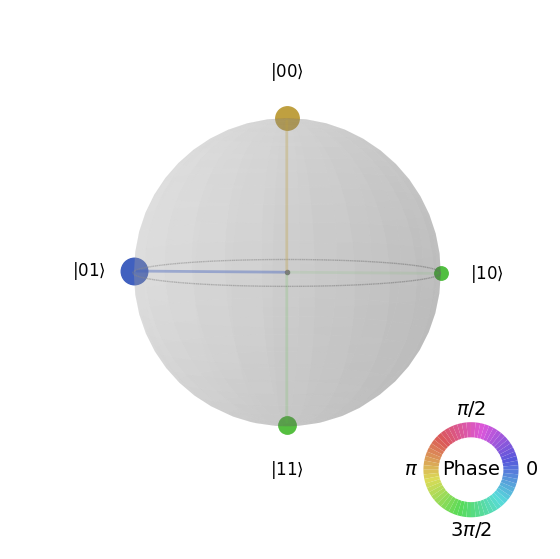

In [ ]:
from qiskit.visualization import plot_state_qsphere

plot_state_qsphere(dm(rho_est.full()).to_statevector())

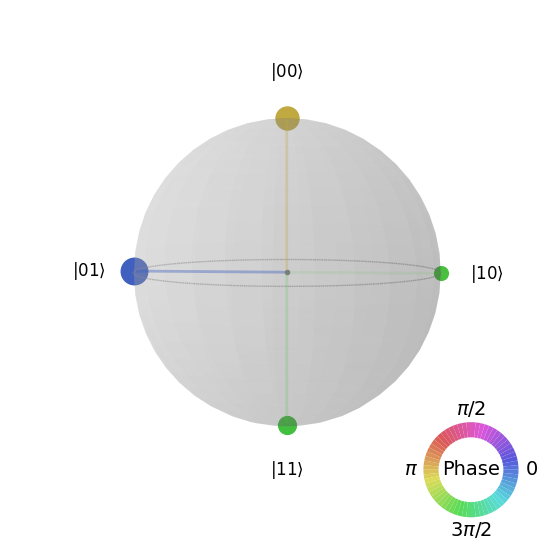

In [ ]:
rho = valid_state(rho)
plot_state_qsphere(dm(rho.full()).to_statevector())

In [ ]:
dm(rho.full()).to_statevector().data

array([-0.55006408-0.04403705j,  0.63637938+0.j        ,
       -0.10956062-0.30946691j, -0.12087201-0.41003439j])

In [ ]:
dm(rho_est.full()).to_statevector().data

array([-0.56263935-0.00333035j,  0.63707695+0.j        ,
       -0.12554177-0.29640889j, -0.17500536-0.37856702j])

In [ ]:
# Trace distance
qt.tracedist(Qobj(rho),Qobj(rho_est))

0.04206842738416691

In [ ]:
import gdown
!mkdir data
urls = ["https://drive.google.com/uc?export=download&id=10tuyl8CXxqBOdAUR5tCSW4UPCMtNELly"]
outputs = ["dataset.csv"]
for url,output in zip(urls,outputs):
  gdown.download(url, f'data/{output}', quiet=False)


In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np

In [ ]:
df = pd.read_csv("data/dataset.csv", header=0, index_col=0)

In [ ]:
print(df.info())
print(df.describe())

In [ ]:
"""Checking if there's any missing values."""
df.isna().sum()

In [ ]:
"""Check if there's any highly correlated feature(s)."""
cor_mat = df.corr().abs()
cor_mat

In [ ]:
"""We have some highly correlated features. We can remove them to reduce collinearity."""
"""We need to create an upper triangle"""
upp_tri = cor_mat.where(np.triu(np.ones(cor_mat.shape), k=1).astype(np.bool))
upp_tri

"""We can see what the highly correlated features are"""
to_drop = [col for col in upp_tri.columns if any(upp_tri[col] > 0.95)]
print(to_drop)

In [ ]:
"""Now we drop these highly correlated features"""
df1 = df.drop(df[to_drop], axis=1)

In [ ]:
"""Check if there's any feature(s) that has extreme values (outliers)."""
have_outliers = []
for i in df1.columns:
"""So if a feature has its max larger than 0.99 quantile, we can say that it 
has outliers."""
  if df1[i].max() > df1[i].quantile(0.99):
    have_outliers.append(i)

print(have_outliers)

In [ ]:
"""Plot the histogram to see the distribution"""
fig, axs = plt.subplots(len(have_outliers), figsize=(8, 36))
for i, v in enumerate(have_outliers):
  sns.histplot(df1[v], ax=axs[i], kde=True)
  axs[i].set_title(v)
fig.tight_layout(pad=2.0)

In [ ]:
"""Then plot the QQ"""
fig, axs = plt.subplots(len(have_outliers), figsize=(12, 32))
for i, v in enumerate(have_outliers):
  stats.probplot(df1[v], dist='norm', plot=axs[i])
  axs[i].set_title(v)
fig.tight_layout(pad=1.0)

"""Conclusion: Wind_speed and Rainfall are pretty bad... We need to think of a 
solution for them"""